<a href="https://colab.research.google.com/github/mkrauter/TrussGame/blob/master/truss_game_AI_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Neural network training for the Truss game

This is the Google Colab notebook for training the convolutional neural network model to be used in the Truss game.

Read more about the idea at ['Is a fruit fly a smarter engineer than you?'](https://marton-krauter.medium.com/is-a-fruit-fly-a-smarter-engineer-than-you-850db1031fe8)


## Setting up the environment

Let's import the necessary modules and check if the virtual machine is working fine.

In [1]:
import os, datetime
import tensorflow as tf
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard
print("Num GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 0


You should see 'Num GPUs available: 1', indicating the the virtual machine is set up and running correctly.

Next we install and import the Pygame package and configure it to run without a display.

In [2]:
!pip install pygame
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame

     |████████████████████████████████| 11.8 MB 14.5 MB/s 
pygame 2.0.1 (SDL 2.0.14, Python 3.7.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Preparing the training dataset

In order to train our neural network first we need to provide significant number of sample data (input-output pairs) to let the model learn from.

Two tasks needed to be done

1.   Create sample data and make it available for our virtual machine
2.   Convert sample data into a consumable format

##Data feed methods

Creating sample images from the game itself on your local computer is really a trivial task, Pygame has functions to capture any region of the window at any time. We may write a iterative function to create a random truss, save the screen as an image, solve the truss system to get the displacement and write the result coordinates to a text file.

Making the images available to our virtual (training) machine is where things start to get a bit complicated. First, you will need to upload the images to a folder in your Google Drive (for 2000 images this will definitely take some time), then you can mount your Google Drive here in the virtual machine to gain access to data for further processing.

We may optimize this process slightly by instead of saving images putting them into a Numpy array. Numpy has a functionality to save data structures to a file (think of how Pickle works), it even compresses them thus we need to transfer only one file, speeding up the process significantlty.

There is another problem with this approach. By their nature Numpy arrays need to fit entirely into the memory (here the memory of the virtual machine). This puts a hard limit on choosing the size of the training set, over 2000 samples you most probably will run out of memory.

We have a solution for both issues:
1.  We may utilize that our game (thus the training data) is purely synthetic. We can generate any number of samples in just a matter of seconds, so doing it _in situ_, in our Colab virtual machine sounds like a good plan, we don't need to transfer any data then.
2.  Tensorflow, the machine learning framework running behind Colab has its own optimized data structure ```tfrecord``` for storing training data. It is definitely not the easiest thing to understand at first, but using it avoids memory issues and it also has functions you may find useful later in your journey.

For the sake of simplicity we use Numpy way of feeding, but later I will update this part with the proper TFrecord method.

Enough talking, let's roll up our sleeves...

#Generate our data

The following code block is a simplified copy of the classes from ```truss_game_AI.py``` from the repo. Having copies of the codebase can quickly lead to problems, but I wanted to keep the code fully modifiable. Long story short, if you modify your local version, please make sure to keep this one in sync.


In [3]:
class TrussGameAI:
    def __init__(self, window_size=(900, 900), force=100000):
        pygame.init()
        pygame.display.init()
        self.screen = pygame.display.set_mode(window_size)
        self.clock = pygame.time.Clock()
        self.force = force

    def __draw_truss(self):
        self.__draw_triangle(pos=self.truss.nodes[self.truss.supports], color=(64, 128, 64))
        self.__draw_triangle(pos=self.truss.nodes_moved[self.truss.loaded_node], color=(100, 100, 200), up=False)
        for i, e in enumerate(self.truss.elements):
            pygame.draw.aaline(self.screen, self.__stress_color(self.truss.sigmas[i]),
                               self.truss.nodes_moved[e[0]], self.truss.nodes_moved[e[1]])

    def __draw_triangle(self, pos, color, up=True, size=(10, 20)):
        direction = 1 if up else -1
        [pygame.draw.polygon(self.screen, color, [p,
                                                  (p[0] - size[0], p[1] + size[1]*direction),
                                                  (p[0] + size[0], p[1] + size[1]*direction)]) for p in pos]

    @staticmethod
    def __stress_color(sigma, scale=3):
        return (int(max(min(-sigma*scale + 255, 255), 0)),
                int(max(min(255 - abs(sigma*scale), 255), 0)),
                int(max(min(sigma*scale + 255, 255), 0)))


    def save_training_set(self, count, region=(68, 68, 768, 768)):
        images = []
        coords = []
        coords_start = []
        for i in range(count):
            self.truss = Truss()
            self.screen.fill(pygame.Color('grey25'))
            self.__draw_truss()
            self.truss.calculate(self.force)
            images.append(pygame.surfarray.array3d(self.screen.subsurface(region)).swapaxes(0,1))
            coords.append(self.truss.nodes_moved[self.truss.loaded_node][0])
            coords_start.append(self.truss.nodes[self.truss.loaded_node][0])
        images, coords, coords_start = np.asarray(images), np.asarray(coords), np.asarray(coords_start)
        np.savez_compressed('Truss_training_dataset', images=images, coords=coords, coords_start=coords_start)


class Truss:
    def __init__(self, size=(700, 500), num_nodes=10, min_distance=100, offset=100):
        points = []
        while len(points) < num_nodes:
            point = size * np.random.rand(2) + offset
            for p in points:
                if np.linalg.norm(point-p) < min_distance: break
            else: points.append(point)
        triangles = scipy.spatial.Delaunay(points)
        self.nodes = triangles.points
        self.elements = np.unique([sorted([s[i], s[(i+1) % 3]]) for s in triangles.simplices for i in range(3)], axis=0)
        self.supports = [np.argmin(self.nodes[:, 0]), np.argmax(self.nodes[:, 0])]
        moving_nodes = np.delete(np.arange(num_nodes), self.supports)
        self.loaded_node = [np.random.choice(moving_nodes)]
        self.moving_rows = np.sort(np.concatenate([moving_nodes*2, moving_nodes*2+1]))
        self.sigmas = np.zeros([len(self.elements), 1])
        self.nodes_moved = self.nodes

    def calculate(self, force, E=200, A=1000):
        vector_size = len(self.nodes)*2
        K = np.zeros((vector_size, vector_size))
        f = np.zeros((vector_size, 1))
        u = np.zeros((vector_size, 1))
        for loaded_node in self.loaded_node:
            f[loaded_node * 2 + 1, 0] = force
        for e in self.elements:
            rows, length, c, s = self.__convert_global(e, nodes)
            K[np.ix_(rows, rows)] += E*A/length * np.array([[c**2, c*s, -c**2, -c*s],
                                                            [c*s, s**2, -c*s, -s**2],
                                                            [-c**2, -c*s, c**2, c*s],
                                                            [-c*s, -s**2, c*s, s**2]])
        u[self.moving_rows] = np.linalg.solve(K[np.ix_(self.moving_rows, self.moving_rows)], f[self.moving_rows])
        self.nodes_moved = self.nodes + np.reshape(u, (len(self.nodes), 2))
        for i, e in enumerate(self.elements):
            rows, length, c, s = self.__convert_global(e, nodes_moved)
            d = np.dot([[c, s, 0, 0],
                        [0, 0, c, s]], u[rows])
            self.sigmas[i] = E * (d[1] - d[0]) / length

    def __convert_global(self, e, nodes):
        rows = [e[0]*2, e[0]*2+1, e[1]*2, e[1]*2+1]
        dx, dy = (self.nodes[e[1], 0] - self.nodes[e[0], 0]), (nodes[e[1], 1] - nodes[e[0], 1])
        length = np.linalg.norm((dx, dy))
        c, s = dx/length, dy/length
        return rows, length, c, s

Let's generate 2000 sample image-coordinate pairs and save it to the disk. This takes slightly more than a minute.

In [5]:
tg = TrussGameAI()
tg.save_training_set(count=2000)
del tg
print('Training dataset created successfully.')

Training dataset created successfully.


Load back the data, and separate the different data types.

In [6]:
dataset = np.load('/content/Truss_training_dataset.npz')
images = dataset['images']
coords = dataset['coords']
coords_start = dataset['coords_start']
del dataset
print(f'Images {images.shape} and coordinates {coords.shape} loaded successfully.')


Images (2000, 768, 768, 3) and coordinates (2000, 2) loaded successfully.


We preserve 20% of the training samples for validation. Validation helps revealing if our model has a tendency to 'overfit', which occurs if our model -- instead of learning information useful in general -- starts to learn information specific to the training data itself, thus to perform remarkably worse on 'never seen' samples.

In [7]:
validation_split = 0.2
validation_count = int(validation_split * len(images))
train_images, train_coords = images[validation_count:], coords[validation_count:]
val_images, val_coords = images[:validation_count], coords[:validation_count]
print(f'Training images {train_images.shape} and coordinates {train_coords.shape} allocated.')

(1600, 768, 768, 3)

#Build the convolutional neural network

Let's construct our model:

In [8]:
model = tf.keras.Sequential([
  tf.keras.Input(shape=(768, 768, 3)),
  tf.keras.layers.experimental.preprocessing.Resizing(256, 256),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  # tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(2, activation='linear')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss="mse", metrics="mae")

model.summary()

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 121, 121, 32)      9

#Train the model

We have all set, only executing the training left. We keep it running for 50 epochs (think of it as learning repetition cycle). Running it any longer will not improve performance, but will just introduce an ever increasing overfit.

The training process typically takes about 10 minutes.

In [ ]:
model.fit(train_images, train_coords, epochs=50, validation_data=(val_images, val_coords), callbacks=[tensorboard_callback])

Epoch 1/50
50/50 [==============================] - 560s 11s/step - loss: 108222.3281 - mae: 266.1209 - val_loss: 26522.7500 - val_mae: 136.7815
Epoch 2/50
50/50 [==============================] - 572s 11s/step - loss: 29379.6504 - mae: 144.4532 - val_loss: 27375.0859 - val_mae: 137.6016
Epoch 3/50
50/50 [==============================] - 556s 11s/step - loss: 29954.3574 - mae: 146.2423 - val_loss: 27161.7891 - val_mae: 137.6033
Epoch 4/50
50/50 [==============================] - 556s 11s/step - loss: 32339.1934 - mae: 148.8018 - val_loss: 31197.0918 - val_mae: 144.6190
Epoch 5/50
50/50 [==============================] - 557s 11s/step - loss: 30449.5547 - mae: 145.9675 - val_loss: 26523.2031 - val_mae: 136.9295
Epoch 6/50
50/50 [==============================] - 572s 11s/step - loss: 29622.0391 - mae: 144.3887 - val_loss: 26391.2500 - val_mae: 136.5642
Epoch 7/50
50/50 [==============================] - 570s 11s/step - loss: 29554.5645 - mae: 143.4848 - val_loss: 26205.8730 - val_mae: 

##Evaluate the training process

Tensorflow has a useful tool called ```Tensorboard``` that helps evaluating the training process based on the saved log files:

In [ ]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 1070), started 3:47:44 ago. (Use '!kill 1070' to kill it.)

<IPython.core.display.Javascript object>

Let's check if our model can predict 

In [ ]:
model.predict(images[:5])

NameError: ignored

Seemingly it shows some signs of life, however that list of coordinates is not that easy to evaluate. Let's create a more meaningful representation.

+ ground truth
x prediction


ValueError: ignored

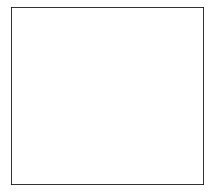

In [ ]:
def show_example_set(start_from=0):
  print('+ ground truth\nx prediction')
  pad_size = 100
  plt.figure(figsize=(20,15))
  for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    prediction = model.predict(images[0][0])
    img = images[start_from+i]
    c = 64
    img = np.pad(img, pad_width=[(pad_size,pad_size), (pad_size,pad_size), (0,0)], 
                 mode='constant', constant_values=[(c,c),(c,c),(c,c)])
    plt.imshow(img)
    new_pos = coords[start_from+i] + pad_size
    start_pos = coords_start[start_from+i] + pad_size
    plt.plot(new_pos[0], new_pos[1], 'w+')
    plt.plot(prediction[0,0], prediction[0,1], 'yx')
    plt.xlabel(f'{start_from+i}: {accuracy(start_pos, new_pos, prediction):.0f}%').set_color("white")
  plt.show()

def accuracy(start_pos, new_pos, prediction):
    return max(0, (1 - np.linalg.norm(prediction - new_pos) / np.linalg.norm(start_pos - new_pos))) * 100

show_example_set(0)

Let's check the overall accuracy of our model:

In [ ]:
print(f'Overall accuracy: {accuracy(coords_start, coords, model.predict(images)):.0f}%')

Overall accuracy: 65%


#Save the trained model

Finally save and convert our model to the Tensorflow lite format:

In [ ]:
model_name = 'truss_game_AI_model'
model.save(model_name)
converter = tf.lite.TFLiteConverter.from_saved_model(model_name)
tflite_model = converter.convert()
with open('/content/' + model_name + '.tflite', 'wb') as f:
  f.write(tflite_model)

To use the model in the game, all you need to do is to download the tflite model file and overwrite the existing one in your local code repo.

Have fun experimenting!